# **The Stokes equations**
**Johan Hoffman**

Lab: Josephine Thuvander

# **Abstract**

This short report show an example on how to use FEniCS to solve the Stokes equations, which is used in the course DD2365 Advanced Computation in Fluid Mechanics, at the KTH Royal Institute of Technology.

[DD2365 course website.](https://kth.instructure.com/courses/17071)

# **About the code**

In [ ]:
"""This program is an example file for the course"""
"""DD2365 Advanced Computation in Fluid Mechanics, """
"""KTH Royal Institute of Technology, Stockholm, Sweden."""

# Copyright (C) 2020 Johan Hoffman (jhoffman@kth.se)

# This file is part of the course DD2365 Advanced Computation in Fluid Mechanics
# KTH Royal Institute of Technology, Stockholm, Sweden
#
# This is free software: you can redistribute it and/or modify
# it under the terms of the GNU Lesser General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

# This template is maintained by Johan Hoffman
# Please report problems to jhoffman@kth.se

'KTH Royal Institute of Technology, Stockholm, Sweden.'

# **Set up environment**

In [ ]:
# Load neccessary modules.
from google.colab import files

import numpy as np
import time


## 
#Import library
from IPython.display import Image



# Install FEniCS
try:
    import dolfin
except ImportError as e:
    !apt-get install -y -qq software-properties-common
    !add-apt-repository -y ppa:fenics-packages/fenics
    !apt-get update -qq
    !apt install -y --no-install-recommends fenics
    !sed -i "s|#if PETSC_VERSION_MAJOR == 3 && PETSC_VERSION_MINOR <= 8 && PETSC_VERSION_RELEASE == 1|#if 1|" /usr/include/dolfin/la/PETScLUSolver.h
    !rm -rf /usr/lib/python3/dist-packages/mpi4py*
    !rm -rf /usr/lib/python3/dist-packages/petsc4py*
    !rm -rf /usr/lib/python3/dist-packages/slepc4py*
    !rm -rf /usr/lib/petsc/lib/python3/dist-packages/dolfin*
    !rm -rf /usr/lib/petsc/lib/python3/dist-packages/mshr*
    !wget "https://drive.google.com/uc?export=download&id=1cT_QBJCOW_eL3BThnval3bcpb8o0w-Ad" -O /tmp/mpi4py-2.0.0-cp37-cp37m-linux_x86_64.whl
    !wget "https://drive.google.com/uc?export=download&id=119i49bxlGn1mrnhTNmOvM4BqmjrT9Ppr" -O /tmp/petsc4py-3.7.0-cp37-cp37m-linux_x86_64.whl
    !wget "https://drive.google.com/uc?export=download&id=1-1tVfu8qz3bRC2zvR8n3RESpesWqNnn6" -O /tmp/slepc4py-3.7.0-cp37-cp37m-linux_x86_64.whl
    !wget "https://drive.google.com/uc?export=download&id=1-3qY4VIJQaXVO1HfGQIzTIURIeJbvX-9" -O /tmp/fenics_dolfin-2019.2.0.dev0-cp37-cp37m-linux_x86_64.whl
    !wget "https://drive.google.com/uc?export=download&id=1-5SMjgjMuee_9WLeYtGe8N_lvipWEN7W" -O /tmp/mshr-2019.2.0.dev0-cp37-cp37m-linux_x86_64.whl
    !pip3 install /tmp/mpi4py-2.0.0-cp37-cp37m-linux_x86_64.whl --upgrade
    !pip3 install /tmp/petsc4py-3.7.0-cp37-cp37m-linux_x86_64.whl --upgrade
    !pip3 install /tmp/slepc4py-3.7.0-cp37-cp37m-linux_x86_64.whl --upgrade
    !pip3 install /tmp/fenics_dolfin-2019.2.0.dev0-cp37-cp37m-linux_x86_64.whl --upgrade
    !pip3 install /tmp/mshr-2019.2.0.dev0-cp37-cp37m-linux_x86_64.whl --upgrade
    !pip3 -q install --upgrade sympy
    import dolfin

from dolfin import *; from mshr import *

import dolfin.common.plotting as fenicsplot

from matplotlib import pyplot as plt

# **Introduction**

The Stokes equations take the form

$\nabla p -\Delta u = f,\quad \nabla \cdot u=0$

together with suitable boundary conditions.

Here we present a FEniCS implementation of a mixed finite element method to solve the Stokes equations in 2D. The solution is visualized using FEniCS plotting functions, and is also exported as pvd-files which can be visualized in Paraview.

To derive the weak form of the equations, multiply the momentum equation by $v\in V$ and the continuity equation by $q\in Q$, and then integrate over the domain $\Omega$ and use Green's formula
$
(\nabla p -\Delta u,v) = -(p,\nabla \cdot v) + (\nabla u, \nabla v) 
+ <pn - \nabla u\cdot n, v>_{\Gamma}
$

We seek a finite element approximation $(u,p)\in V\times Q$ such that 

$- (p,\nabla \cdot v) + (\nabla u,\nabla v) + (\nabla \cdot u, q) 
+ <pn - \nabla u\cdot n, v>_{\partial \Omega} = (f,v)$

for all test functions $(v,q) \in V\times Q$. 

$
(v,w) = \int_{\Omega} v\cdot w ~dx, \quad 
<v,w>_{\partial \Omega} = \int_{\partial \Omega} v\cdot w~ds
$

We divide the boundary into $\partial \Omega=\Gamma_D \cup \Gamma_N$, with the different boundary conditions

$
u = g_D,\quad x\in \Gamma_D,
$

$
-\nu \nabla u\cdot n + pn = g_N, \quad x\in \Gamma_N,
$

For $x\in \Gamma_D$ the test function $v=0$. Hence, with $g_N=0$ the boundary term is zero. 

The equations can be expressed in residual form

$r(u,p;v,q) = - (p,\nabla \cdot v) + (\nabla u,\nabla v) + (\nabla \cdot u, q) - (f,v)$

We use inf-sup stable Taylor-Hood approximation spaces, 
and to implement the velocity boundary conditions we use a penalty formulation, with a penalty parameter $\gamma = C/h$, with $C>0$ a constant and $h$ the local mesh size. At outflow we use a "do nothing" stress free boundary condition. 


# **Method**

**Define domain and mesh**

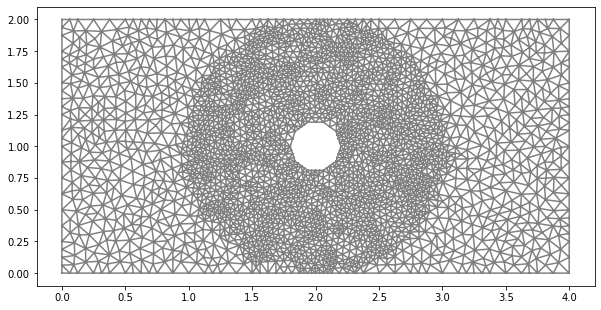

In [ ]:
# Define rectangular domain 
L = 4
H = 2

# Generate mesh (examples with and without a hole in the mesh) 
resolution = 32
#mesh = RectangleMesh(Point(0.0, 0.0), Point(L, H), L*resolution, H*resolution)
mesh = generate_mesh(Rectangle(Point(0.0,0.0), Point(L,H)) - Circle(Point(0.5*L,0.5*H),0.2), resolution)
#mesh = generate_mesh(Rectangle(Point(0.0,0.0), Point(L,H)) - Circle(Point(1.5,0.25*H),0.2) - Circle(Point(0.5,0.5*H),0.2) - Circle(Point(2.0,0.75*H),0.2), resolution)

# Local mesh refinement (specified by a cell marker)
no_levels = 1
for i in range(0,no_levels):
  cell_marker = MeshFunction("bool", mesh, mesh.topology().dim())
  for cell in cells(mesh):
    cell_marker[cell] = False
    p = cell.midpoint()
    if p.distance(Point(2.0, 1.0)) < 1.0:
        cell_marker[cell] = True
  mesh = refine(mesh, cell_marker)

#plt.figure()
plt.figure(figsize=(10,10))
plot(mesh)
plt.show()

**Define finite element approximation spaces**

In [ ]:
# Generate mixed finite element spaces (for velocity and pressure)
VE = VectorElement("CG", mesh.ufl_cell(), 1)
QE = FiniteElement("CG", mesh.ufl_cell(), 1)
WE = VE * QE

W = FunctionSpace(mesh, WE)
V = FunctionSpace(mesh, VE)
Q = FunctionSpace(mesh, QE)

# Define trial and test functions
w = Function(W)
(u, p) = (as_vector((w[0],w[1])), w[2])
(v, q) = TestFunctions(W) 

**Define boundary conditions**

In [ ]:
# Examples of inflow and outflow conditions
XMIN = 0.0; XMAX = L
YMIN = 0.0; YMAX = H
uin = Expression(("4*(x[1]*(YMAX-x[1]))/(YMAX*YMAX)", "0."), YMAX=YMAX, element = V.ufl_element()) 
#uin = Expression(("-4*(x[1]*(YMAX-x[1]))/(YMAX*YMAX)", "0."), YMAX=YMAX, element = V.ufl_element()) # change direction of flow
#pout = 0.0

# Inflow boundary (ib), outflow boundary (ob) and wall boundary (wb)
ib = Expression("near(x[0],XMIN) ? 1. : 0.", XMIN=XMIN, element = Q.ufl_element())
#ib = Expression("near(x[0],XMAX) ? 1. : 0.", XMAX=XMAX, element = Q.ufl_element()) # inflow boundary right side
#ob = Expression("near(x[0],XMAX) ? 1. : 0.", XMAX=XMAX, element = Q.ufl_element())
wb = Expression("x[0] > XMIN + DOLFIN_EPS && x[0] < XMAX - DOLFIN_EPS ? 1. : 0.", XMIN=XMIN, XMAX=XMAX, element = Q.ufl_element())

## **Results**

**Define and solve variational problem**

In [ ]:
h = CellDiameter(mesh)
C = 1.0e3
gamma = C/h

f = Expression(("0.0","0.0"), element = V.ufl_element())

# Define variational problem on residual form: r(u,p;v,q) = 0
residual = ( - p*div(v)*dx + inner(grad(u), grad(v))*dx + div(u)*q*dx + 
            gamma*(ib*inner(u - uin, v) + wb*inner(u, v))*ds - inner(f, v)*dx )

# Solve algebraic system 
solve(residual == 0, w) 

**Visualize solution and export files**

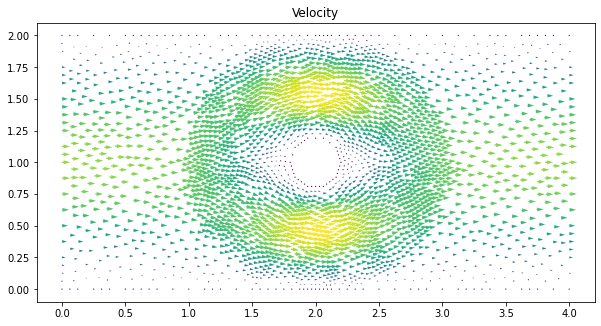

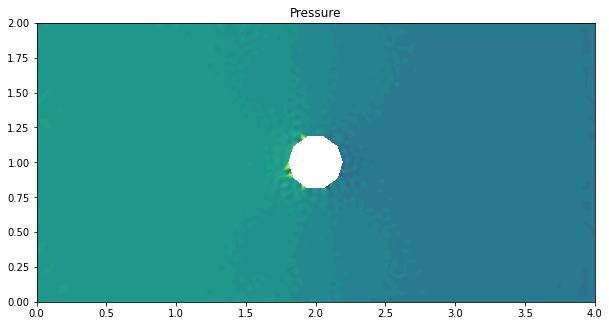

In [ ]:
!rm results-Stokes/*

# Open files to export solution to Paraview
file_u = File("results-Stokes/u.pvd")
file_p = File("results-Stokes/p.pvd")

u1 = project(u, V)
p1 = project(p, Q)

# Save solution to file
file_u << u1
file_p << p1

# Plot solution
#plt.figure()
plt.figure(figsize=(10,10)) 
plot(u1, title="Velocity")

plt.figure(figsize=(10,10))
plot(p1, title="Pressure")
        
plt.show()

# Export files
#!tar -czvf results-Stokes.tar.gz results-Stokes
#files.download('results-Stokes.tar.gz')

## **Discussion**

A Taylor-Hood mixed finite element method was implemented in FEniCS to solve the Stokes equations in 2D. The method was tested for the model problem of flow past a number of circular obstacles, and the solution behaved as expected. 

We use a computational domain containing a circular hole in the center, and a uniform mesh of size $h=\frac{1}{32}$. The mesh is refined locally in a cirlce with radius of 1 around the hole, shown in the plot below.

![picture](https://drive.google.com/uc?id=1GXjjz1dJ_SIe5sAPMh739paQeT3HcAy6)

Using linear approximating spaces for both the velocity and pressure, we see that the pressure is unstable and oscillating, shown in the plot below.

![picture](https://drive.google.com/uc?id=1pLYmHQsDiBCjy-_STADl4MazHT8xZmbi)

To stabilize the pressure we implement the Taylor-hood mixed element, i.e. we use a quadratic order approximation space for the velocity and a linear approximation space for the pressure. The stabilized pressure and velocity field are shown in the plots below. We see a region of high pressure on the left-hand side of the circle, which is what to expect since the flow is going from left to right. 

![picture](https://drive.google.com/uc?id=1ZhOGpbcJ-3L4FVWr5poAYbAVdVyDHKdE)

![picture](https://drive.google.com/uc?id=1ooATDDqqlvapmJCS9FRzeHA1RKiA8bTS)

We change the direction of the flow so that the fluid flows from right to left. The velocity and pressure plots are shown below. Changing the flow direction, we see that the pressure now becomes high in the right-hand side of the circle. 

![picture](https://drive.google.com/uc?id=1G2OS4mm3Yd4PsG15h2dd7xxRjKzq_gps)

![picture](https://drive.google.com/uc?id=16AYAWNHghkNEv8r4wNOJB1-CmCm4Nxmp)


